# EDA i czyszczenie

- wczytuję pełny zbiór (największy plik CSV)
- sprawdzam typy i braki
- robię target `lap_time_seconds` i `pit_time_seconds` (braki w pit=0)
- czyszczę i zapisuję dane
- patrzę na outliery i metrykę


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
# Import bibliotek
import pandas as pd

warnings.filterwarnings('ignore')

# Ustawienia
pd.set_option('display.max_columns', None)

print("Gotowe")


Gotowe


## 1. Wczytanie danych


In [2]:
# Wczytanie pełnego zbioru danych
import os
import glob
raw_dir = os.path.join('..', 'data', '01_raw')
raw_csvs = glob.glob(os.path.join(raw_dir, '*.csv'))

if not raw_csvs:
    raise FileNotFoundError(f'Brak plików CSV w katalogu: {raw_dir}')

# Wybór największego pliku
csv_by_size = sorted(raw_csvs, key=lambda p: os.path.getsize(p), reverse=True)
selected_path = csv_by_size[0]

df = pd.read_csv(selected_path)

print(f"Rozmiar zbioru: {df.shape}")


Rozmiar zbioru: (503680, 48)


## 2. Sprawdzenie struktury


In [3]:
# Brakujące wartości
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))


crossing_finish_line_in_pit    475235
pit_time                       475036
flag_at_fl                     473386
group                          423118
top_speed                        1949
s2_large                          281
s2                                274
s3_large                          201
s3                                194
s1_large                          116
s1                                111
dtype: int64


Liczenie braków...
Gotowe. Tworzę wykres...


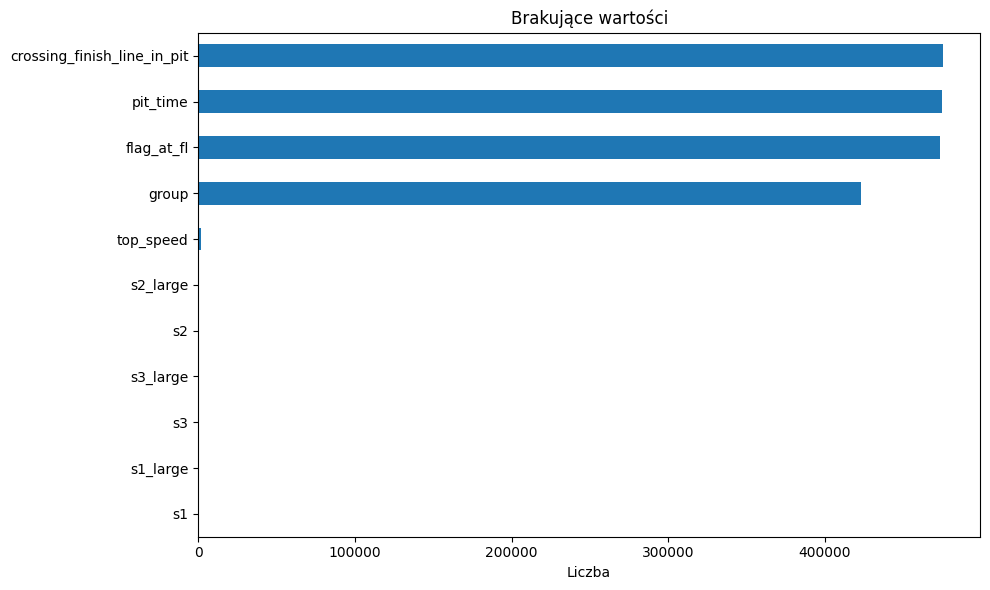

Wykres gotowy. Brakuje w 11 kolumnach.


In [4]:
# Wizualizacja brakujących wartości
print("Liczenie braków...")
missing_data = df.isnull().sum()
print("Gotowe. Tworzę wykres...")
missing_data_plot = missing_data[missing_data > 0].sort_values(ascending=True)
if len(missing_data_plot) > 0:
    plt.figure(figsize=(10, 6))
    missing_data_plot.plot(kind='barh')
    plt.title('Brakujące wartości')
    plt.xlabel('Liczba')
    plt.tight_layout()
    plt.show()
    print(f"Wykres gotowy. Brakuje w {len(missing_data_plot)} kolumnach.")
else:
    print("Brak brakujących wartości!")

## 3. Target - czas okrążeń


In [5]:
# Target i czasy w sekundach

df['lap_time_seconds'] = pd.to_timedelta(df['lap_time'], errors='coerce').dt.total_seconds()
if 'pit_time' in df.columns:
    df['pit_time_seconds'] = pd.to_timedelta(df['pit_time'], errors='coerce').dt.total_seconds()
    df['pit_time_seconds'] = df['pit_time_seconds'].fillna(0)


In [6]:
# Skośność rozkładu czasów okrążeń
skewness = df['lap_time_seconds'].skew(skipna=True)
print(f"Skośność (lap_time_seconds): {skewness:.2f}")
if abs(skewness) > 1:
    print("✓ Potwierdzenie: rozkład jest silnie skośny → MAE jako główna metryka.")


Skośność (lap_time_seconds): 35.37
✓ Potwierdzenie: rozkład jest silnie skośny → MAE jako główna metryka.


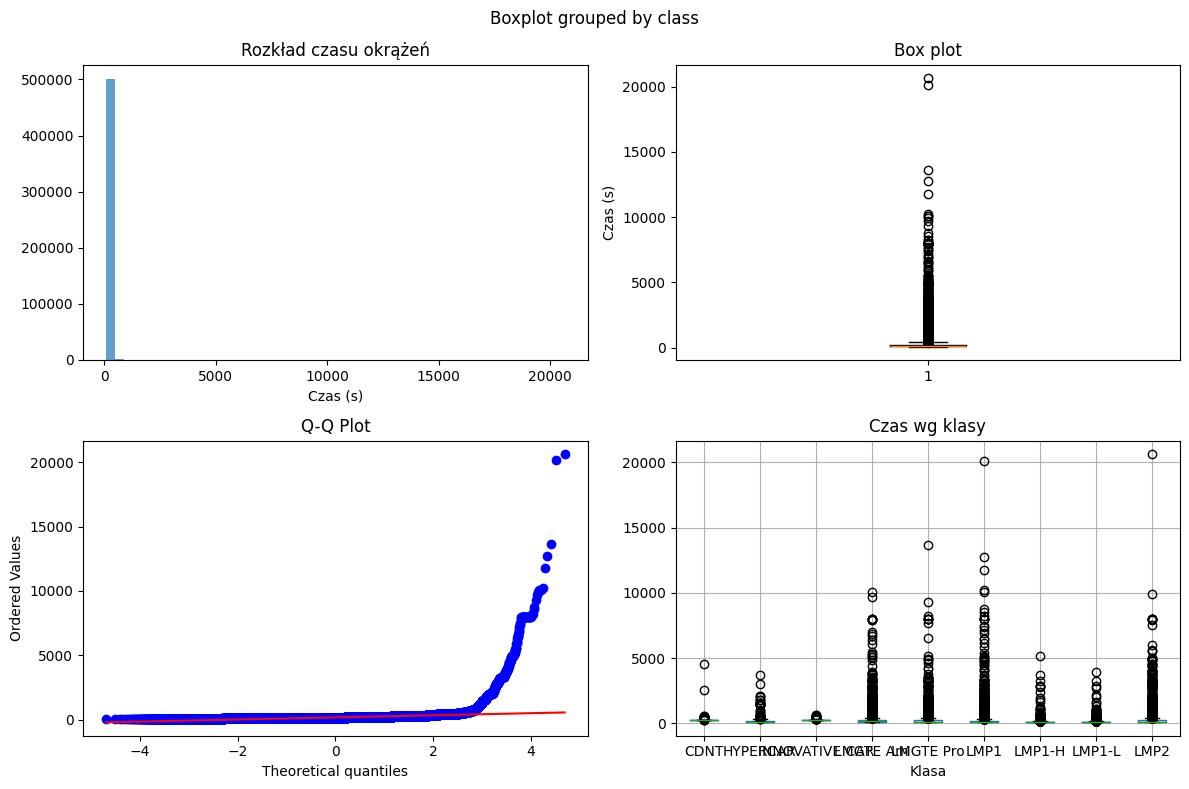

Statystyki:
count    503680.000000
mean        174.438258
std         148.128695
min          78.367000
25%         114.295000
50%         131.123500
75%         227.713000
max       20641.566000
Name: lap_time_seconds, dtype: float64


In [7]:
from scipy import stats
# Wizualizacja rozkładu czasu okrążeń
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Histogram
axes[0,0].hist(df['lap_time_seconds'], bins=50, alpha=0.7)
axes[0,0].set_title('Rozkład czasu okrążeń')
axes[0,0].set_xlabel('Czas (s)')

# Box plot
axes[0,1].boxplot(df['lap_time_seconds'])
axes[0,1].set_title('Box plot')
axes[0,1].set_ylabel('Czas (s)')

# Q-Q plot
stats.probplot(df['lap_time_seconds'], dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot')

# Czas wg klasy samochodu
if 'class' in df.columns:
    df.boxplot(column='lap_time_seconds', by='class', ax=axes[1,1])
    axes[1,1].set_title('Czas wg klasy')
    axes[1,1].set_xlabel('Klasa')

plt.tight_layout()
plt.show()

print("Statystyki:")
print(df['lap_time_seconds'].describe())


## 4. Wizualizacje


In [8]:
# Liczba cech
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print(f"Num: {len(numeric_columns)}, Cat: {len(categorical_columns)}")


Num: 29, Cat: 21


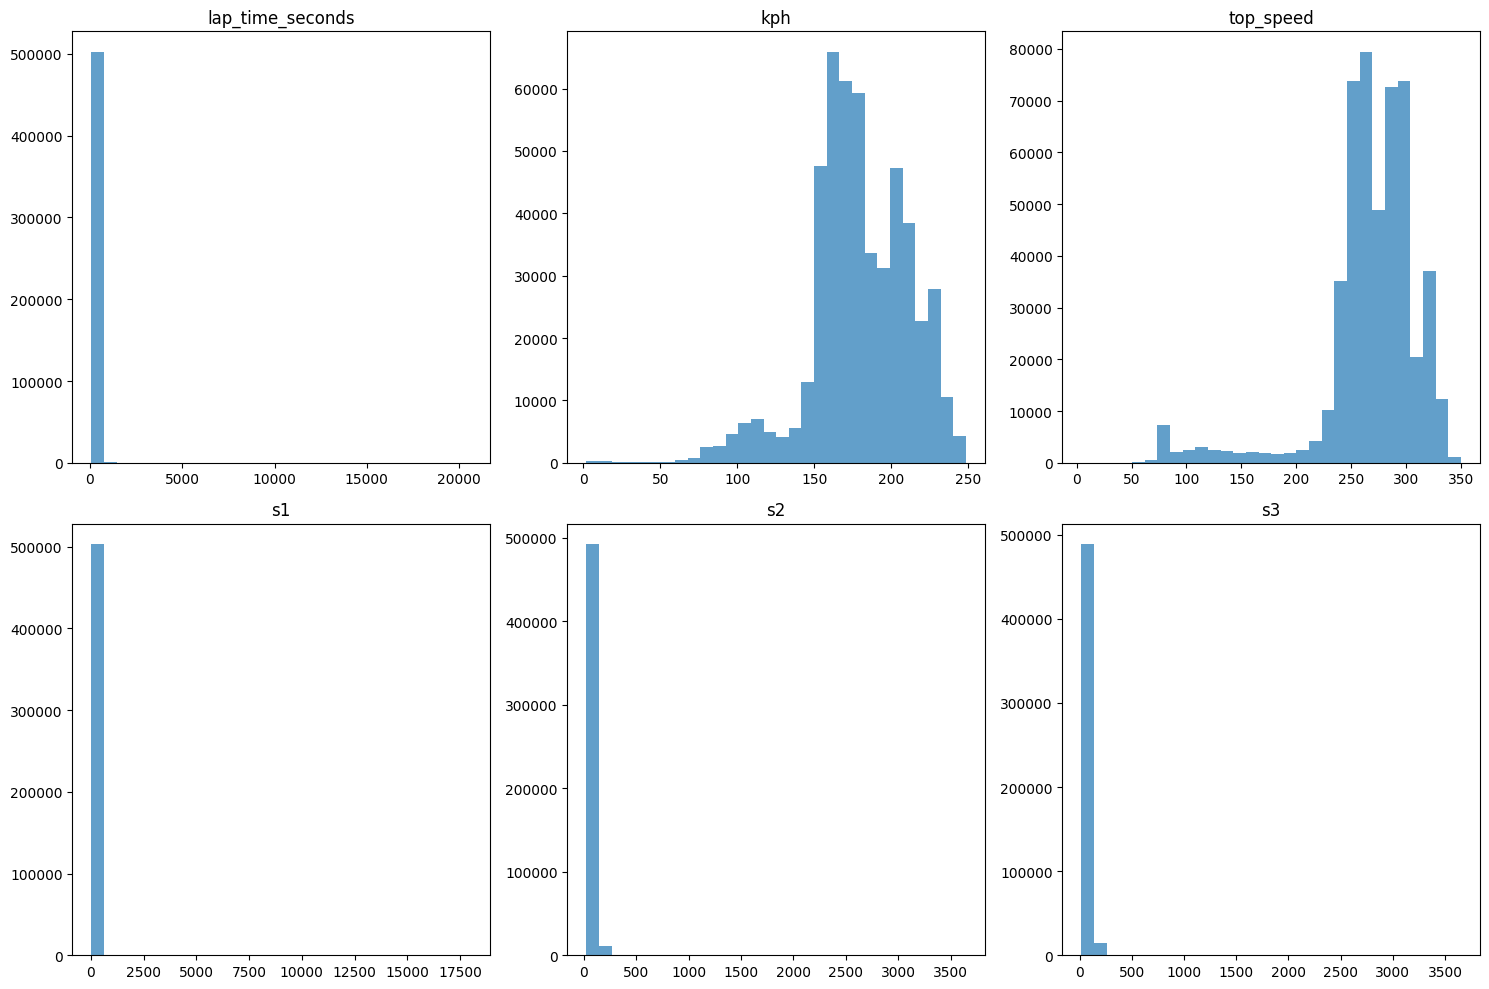

lap_time_seconds    1.000000
lap_time_s          1.000000
lap_time_ms         1.000000
s1                  0.867335
pit_time_seconds    0.743422
s3                  0.503450
s2                  0.487047
gap                 0.292012
elapsed_s           0.277004
elapsed_ms          0.277004
dtype: float64

In [9]:
# Wizualizacja wybranych cech
important_numeric = ['lap_time_seconds', 'kph', 'top_speed', 's1', 's2', 's3']
available_numeric = [col for col in important_numeric if col in df.columns]

if available_numeric:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(available_numeric[:6]):
        if i < len(axes):
            axes[i].hist(df[col].dropna(), bins=30, alpha=0.7)
            axes[i].set_title(f'{col}')
    
    for i in range(len(available_numeric), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Top korelacje z lap_time_seconds
correlations = df[numeric_columns].corrwith(df['lap_time_seconds']).abs().sort_values(ascending=False)
correlations.head(10)


## 5. Czyszczenie danych


In [10]:
# Tworzę kopię do czyszczenia
df_clean = df.copy()

# 1. Usuwam kolumny z >50% braków
cols_to_drop = []
columns_exceptions = {'pit_time', 'pit_time_seconds', 'crossing_finish_line_in_pit'}
for col in df_clean.columns:
    missing_pct = df_clean[col].isnull().sum() / len(df_clean)
    if missing_pct > 0.5 and col not in columns_exceptions:
        cols_to_drop.append(col)

df_clean = df_clean.drop(columns=cols_to_drop)

# 2. Usuwam kolumny stałe
constant_cols = [col for col in df_clean.columns if df_clean[col].nunique() <= 1]
df_clean = df_clean.drop(columns=constant_cols)

print(f"Po wstępnym czyszczeniu: {df_clean.shape}")


Po wstępnym czyszczeniu: (503680, 47)


In [11]:
# 3. Usuwanie wierszy z brakami

# Uzupełnij TYLKO pit_time_seconds zerem
if 'pit_time_seconds' in df_clean.columns:
    df_clean['pit_time_seconds'] = df_clean['pit_time_seconds'].fillna(0)

if 'pit_time' in df_clean.columns:
    df_clean = df_clean.drop(columns=['pit_time'])

# Usuń wiersze z brakami w target (lap_time_seconds) - nie można przewidywać bez celu
if 'lap_time_seconds' in df_clean.columns:
    df_clean = df_clean[df_clean['lap_time_seconds'].notna()]

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'pit_time_seconds' in numeric_cols:
    numeric_cols.remove('pit_time_seconds')

if numeric_cols:
    # Usuń wiersze gdzie jakakolwiek kolumna numeryczna (poza pit) ma braki
    mask = df_clean[numeric_cols].notna().all(axis=1)
    df_clean = df_clean[mask]

# Usuń wiersze z brakami w kluczowych kolumnach kategorii (używane w modelu)
important_categorical = ['class', 'circuit']  # kolumny ważne dla modelu
for col in important_categorical:
    if col in df_clean.columns:
        df_clean = df_clean[df_clean[col].notna()]

# Usuń wiersze z brakami w kolumnach s*_large (małe braki, ale dla pełnej czystości)
large_cols = [col for col in df_clean.columns if col.endswith('_large')]
for col in large_cols:
    if col in df_clean.columns:
        df_clean = df_clean[df_clean[col].notna()]

print(f"Braki po czyszczeniu: {df_clean.isnull().sum().sum()}")
print(f"Wiersze po usunięciu braków: {len(df_clean)} (usunięto {len(df) - len(df_clean)} wierszy)")


Braki po czyszczeniu: 0
Wiersze po usunięciu braków: 501482 (usunięto 2198 wierszy)


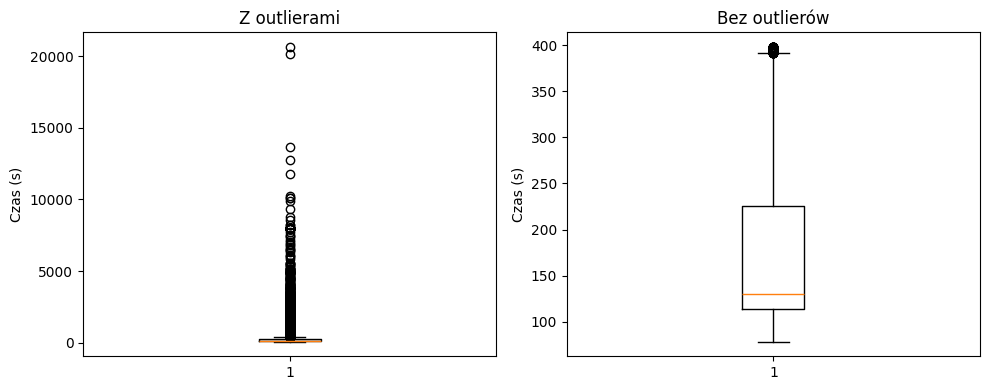

Outliery lap_time: 8897 (1.8%)
Wniosek: długie czasy to zwykle pit - do predykcji pomijam pit.


In [12]:
# 5. Outliery

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Flaga okrążenia z pit
if 'pit_time_seconds' in df_clean.columns:
    df_clean['pit_lap'] = (df_clean['pit_time_seconds'] > 0).astype(int)

# Skala outlierów w lap_time_seconds
outliers, lower, upper = detect_outliers_iqr(df_clean, 'lap_time_seconds')
share_pit = None
if 'pit_lap' in df_clean.columns and len(outliers) > 0:
    share_pit = outliers['pit_lap'].mean()

# Wizualizacja
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(df_clean['lap_time_seconds'])
plt.title('Z outlierami')
plt.ylabel('Czas (s)')

plt.subplot(1, 2, 2)
plt.boxplot(df_clean[(df_clean['lap_time_seconds'] >= lower) & (df_clean['lap_time_seconds'] <= upper)]['lap_time_seconds'])
plt.title('Bez outlierów')
plt.ylabel('Czas (s)')
plt.tight_layout()
plt.show()

print(f"Outliery lap_time: {len(outliers)} ({len(outliers)/len(df_clean)*100:.1f}%)")
if share_pit is not None:
    print("Wniosek: długie czasy to zwykle pit - do predykcji pomijam pit.")


In [13]:
# 5a. Zbiór do modelowania: bez pit + 1–99 pct + 1 klasa

low, high = None, None
if 'lap_time_seconds' in df_clean.columns:
    low, high = df_clean['lap_time_seconds'].quantile([0.01, 0.99])

df_model = df_clean.copy()
if 'pit_time_seconds' in df_model.columns:
    df_model = df_model[df_model['pit_time_seconds'] == 0]
if low is not None and high is not None:
    df_model = df_model[(df_model['lap_time_seconds'] >= low) & (df_model['lap_time_seconds'] <= high)]

CLASS_TO_MODEL = None
if 'class' in df_model.columns and df_model['class'].nunique() > 1:
    CLASS_TO_MODEL = df_model['class'].mode()[0]
    df_model = df_model[df_model['class'] == CLASS_TO_MODEL]

print(f"Zbiór do modelowania: {df_model.shape}; klasa: {CLASS_TO_MODEL}")


Zbiór do modelowania: (155529, 47); klasa: LMP2


In [14]:
import pickle
# 6. Enkodowanie kategorii
from sklearn.preprocessing import LabelEncoder

categorical_cols = df_clean.select_dtypes(include=['object']).columns
le_dict = {}
for col in categorical_cols:
    if df_clean[col].nunique() <= 20:
        le = LabelEncoder()
        df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col].astype(str))
        le_dict[col] = le
        
        # Wyświetl mapowanie (co oznacza każda liczba)
        print(f"\n{col} → {col}_encoded:")
        for original, encoded in zip(le.classes_, range(len(le.classes_))):
            print(f"  '{original}' → {encoded}")

print(f"\nPo enkodowaniu: {df_clean.shape}")
print(f"Zapisano {len(le_dict)} enkoderów w le_dict")


encoder_path = '../data/02_interim/label_encoders.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(le_dict, f)
print(f"Enkodery zapisane do: {encoder_path}")



class → class_encoded:
  'CDNT' → 0
  'HYPERCAR' → 1
  'INNOVATIVE CAR' → 2
  'LMGTE Am' → 3
  'LMGTE Pro' → 4
  'LMP1' → 5
  'LMP1-H' → 6
  'LMP1-L' → 7
  'LMP2' → 8

season → season_encoded:
  '2012' → 0
  '2013' → 1
  '2014' → 2
  '2015' → 3
  '2016' → 4
  '2017' → 5
  '2018-2019' → 6
  '2019-2020' → 7
  '2021' → 8
  '2022' → 9

circuit → circuit_encoded:
  'AUTODROMO DO ALGARVE' → 0
  'AUTODROMO HERMANOS RODRIGUEZ' → 1
  'AUTODROMO NAZIONALE DI MONZA' → 2
  'BAHRAIN INTERNATIONAL CIRCUIT' → 3
  'BAHRAIN INTERNATIONAL CIRCUIT 2019' → 4
  'BAHRAIN INTERNATIONAL CIRCUIT 2020' → 5
  'BAHRAIN INTERNATIONAL CIRCUIT 6 HOURS' → 6
  'BAHRAIN INTERNATIONAL CIRCUIT 8 HOURS' → 7
  'CIRCUIT OF THE AMERICAS' → 8
  'FUJI SPEEDWAY' → 9
  'INTERLAGOS' → 10
  'LE MANS' → 11
  'LE MANS 2018' → 12
  'LE MANS 2019' → 13
  'NURBURGRING' → 14
  'SEBRING' → 15
  'SHANGHAI INTERNATIONAL CIRCUIT' → 16
  'SILVERSTONE' → 17
  'SPA FRANCORCHAMPS' → 18
  'SPA FRANCORCHAMPS 2019' → 19

engine → engine_encoded:


## 6. Wybór metryki

Problem: Regresja- przewidywanie czasu okrążeń (zmienna ciągła)


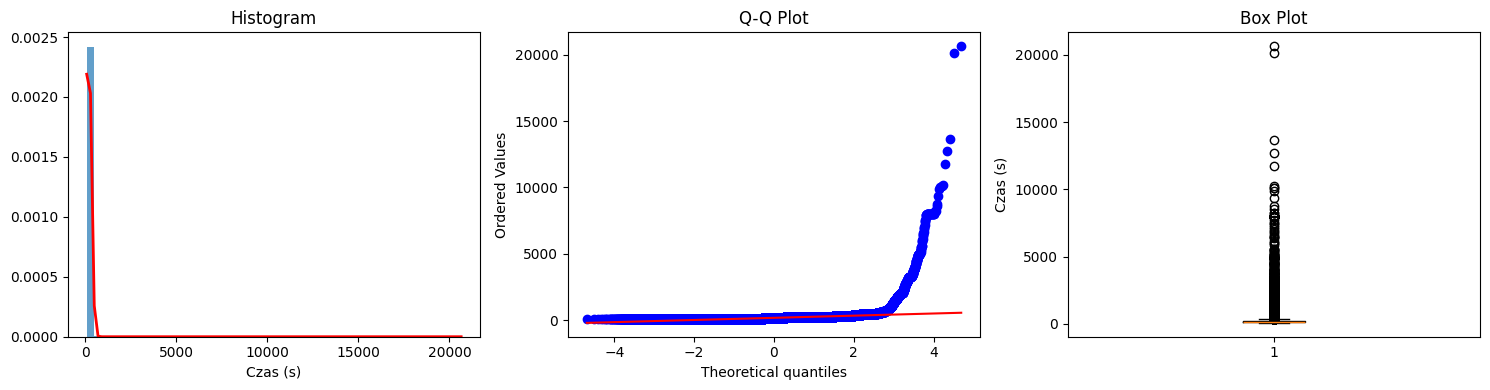

Wniosek: rozkład jest skośny → jako główną metrykę biorę MAE.


In [15]:
# Rozkład czasu okrążeń
from scipy import stats

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df_clean['lap_time_seconds'], bins=50, density=True, alpha=0.7)
mu, sigma = df_clean['lap_time_seconds'].mean(), df_clean['lap_time_seconds'].std()
x = np.linspace(df_clean['lap_time_seconds'].min(), df_clean['lap_time_seconds'].max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2)
axes[0].set_title('Histogram')
axes[0].set_xlabel('Czas (s)')

stats.probplot(df_clean['lap_time_seconds'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')

axes[2].boxplot(df_clean['lap_time_seconds'])
axes[2].set_title('Box Plot')
axes[2].set_ylabel('Czas (s)')
plt.tight_layout()
plt.show()

print("Wniosek: rozkład jest skośny → jako główną metrykę biorę MAE.")


### Wybrane metryki:

1. MAE (Mean Absolute Error) - główna
- Interpretowalne w sekundach, odporne na outliery

2. RMSE (Root Mean Square Error) - dodatkowa
- Kara za duże błędy (ważne w wyścigach)

3. R² (Coefficient of Determination) - dodatkowa
- Jak dobrze model wyjaśnia dane

4. MAPE (Mean Absolute Percentage Error) - dodatkowa
- Błąd w procentach


In [16]:
import os
# Funkcja do obliczania metryk
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

print("Funkcja calculate_regression_metrics() gotowa")

print("\nPodsumowanie:")
print(f"Przed: {df.shape} → Po: {df_clean.shape}")
removed_cols = sorted(list(set(df.columns) - set(df_clean.columns)))
added_cols = sorted(list(set(df_clean.columns) - set(df.columns)))
print("Usunięte kolumny:", removed_cols if removed_cols else "brak")
print("Dodane kolumny:", added_cols if added_cols else "brak")

missing_after = df_clean.isnull().sum()
missing_cols = missing_after[missing_after > 0].sort_values(ascending=False)
if len(missing_cols) > 0:
    print(f"\nBraki po czyszczeniu: {df_clean.isnull().sum().sum()} (w {len(missing_cols)} kolumnach)")
    print("Kolumny z brakami:")
    print(missing_cols.head(10))
    print("\n(Uwaga: te braki są w kolumnach kategorii, które nie zostały usunięte)")
else:
    print(f"\nBraki po czyszczeniu: {df_clean.isnull().sum().sum()}")

# Zapis danych po czyszczeniu

os.makedirs('../data/02_interim', exist_ok=True)
output_path = '../data/02_interim/wec_lap_data_cleaned.csv'
df_clean.to_csv(output_path, index=False)
print(f"\nZapisuję do: {output_path}")


Funkcja calculate_regression_metrics() gotowa

Podsumowanie:
Przed: (503680, 50) → Po: (501482, 51)
Usunięte kolumny: ['crossing_finish_line_in_pit', 'flag_at_fl', 'group', 'pit_time']
Dodane kolumny: ['circuit_encoded', 'class_encoded', 'engine_encoded', 'pit_lap', 'season_encoded']

Braki po czyszczeniu: 0

Zapisuję do: ../data/02_interim/wec_lap_data_cleaned.csv
